In [5]:
import pandas as pd

df = pd.read_csv(r"C:\Users\sinha\OneDrive\Documents\Projects\Bihari Hackathon 2\BiharChalo\bank-fraud-detection\data\processed\final_dataset.csv")
print(df.head())

                         Transaction ID            Timestamp  \
0  02778d52-6da3-4548-8fa8-7386f6f113dc  2024-06-15 10:06:54   
1  9bfa623e-e9a2-4055-a68f-6176799c23ba  2024-06-08 23:57:36   
2  cae64654-236e-4020-a916-683e6e328042  2024-06-21 04:48:20   
3  8880e38a-e352-436b-83d5-b4c3f8321451  2024-06-13 12:52:13   
4  5182e6aa-9323-4fbd-b778-e887dde8a292  2024-07-02 13:07:51   

        Sender Name          Sender UPI ID   Receiver Name  \
0     Saksham Saran       0000990372@okybl       Piya Gade   
1  Anya Subramanian  0007350717@okhdfcbank  Ryan Varughese   
2        Anya Setty      0008732461@okaxis    Riaan Suresh   
3   Lagan Choudhary      0015108332@okaxis   Inaaya  Desai   
4          Rati Jha       0017185135@oksbi  Reyansh Thaman   

         Receiver UPI ID  Amount (INR)   Status        sender_bank  \
0     7509784854@okicici        167.68   FAILED       example_axis   
1       2740886854@oksbi       6009.04   FAILED       example_axis   
2  3052735878@okhdfcbank       7

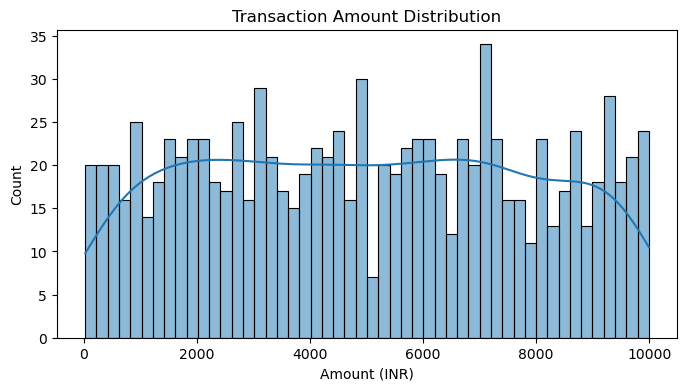

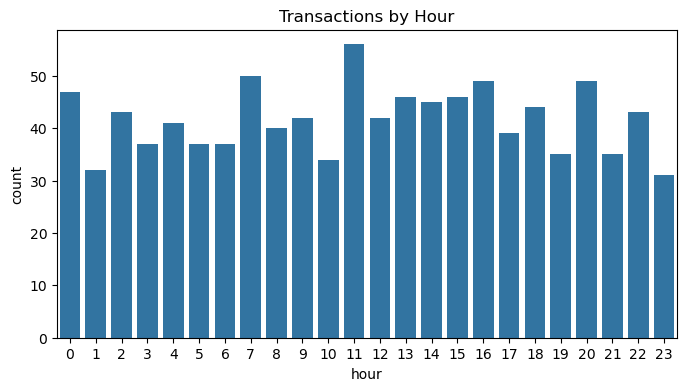

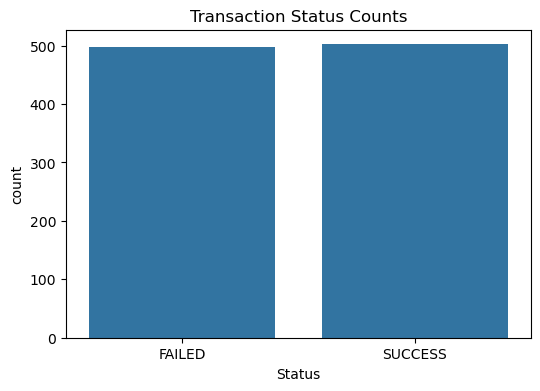

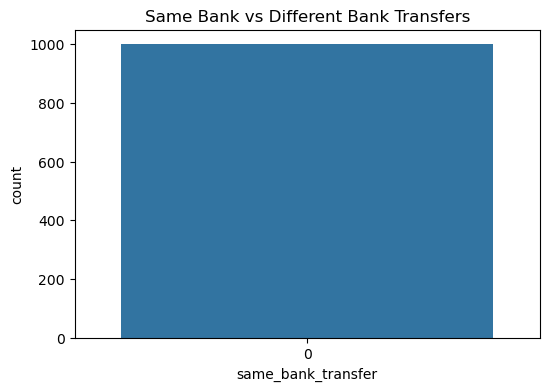

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Amount distribution
plt.figure(figsize=(8,4))
sns.histplot(df['Amount (INR)'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.show()

# Transactions by hour
plt.figure(figsize=(8,4))
sns.countplot(x='hour', data=df)
plt.title('Transactions by Hour')
plt.show()

# Status counts
plt.figure(figsize=(6,4))
sns.countplot(x='Status', data=df)
plt.title('Transaction Status Counts')
plt.show()

# Bank transfer type
plt.figure(figsize=(6,4))
sns.countplot(x='same_bank_transfer', data=df)
plt.title('Same Bank vs Different Bank Transfers')
plt.show()

In [7]:
from sklearn.preprocessing import LabelEncoder

# Select features for anomaly detection
features = [
    'Amount (INR)', 'hour', 'day_of_week', 'is_weekend', 'is_large_amount',
    'same_bank_transfer', 'receiver_repeat_count', 'avg_txn_amt_sender', 'time_gap_seconds'
]

# Fill missing values
df_model = df[features].copy()
df_model = df_model.fillna(0)

# Ensure all are numeric
for col in df_model.columns:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce').fillna(0)

In [8]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
df['anomaly_score'] = model.fit_predict(df_model)

# Flag suspicious transactions
df['is_suspicious'] = (df['anomaly_score'] == -1).astype(int)
print(df['is_suspicious'].value_counts())

c:\Users\sinha\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


is_suspicious
0    970
1     30
Name: count, dtype: int64


In [9]:
fraud_report = df[df['is_suspicious'] == 1]
fraud_report.to_csv(r"C:\Users\sinha\OneDrive\Documents\Projects\Bihari Hackathon 2\BiharChalo\bank-fraud-detection\reports\fraud_report.csv", index=False)
print("Fraud report saved. Number of suspicious transactions:", len(fraud_report))

Fraud report saved. Number of suspicious transactions: 30


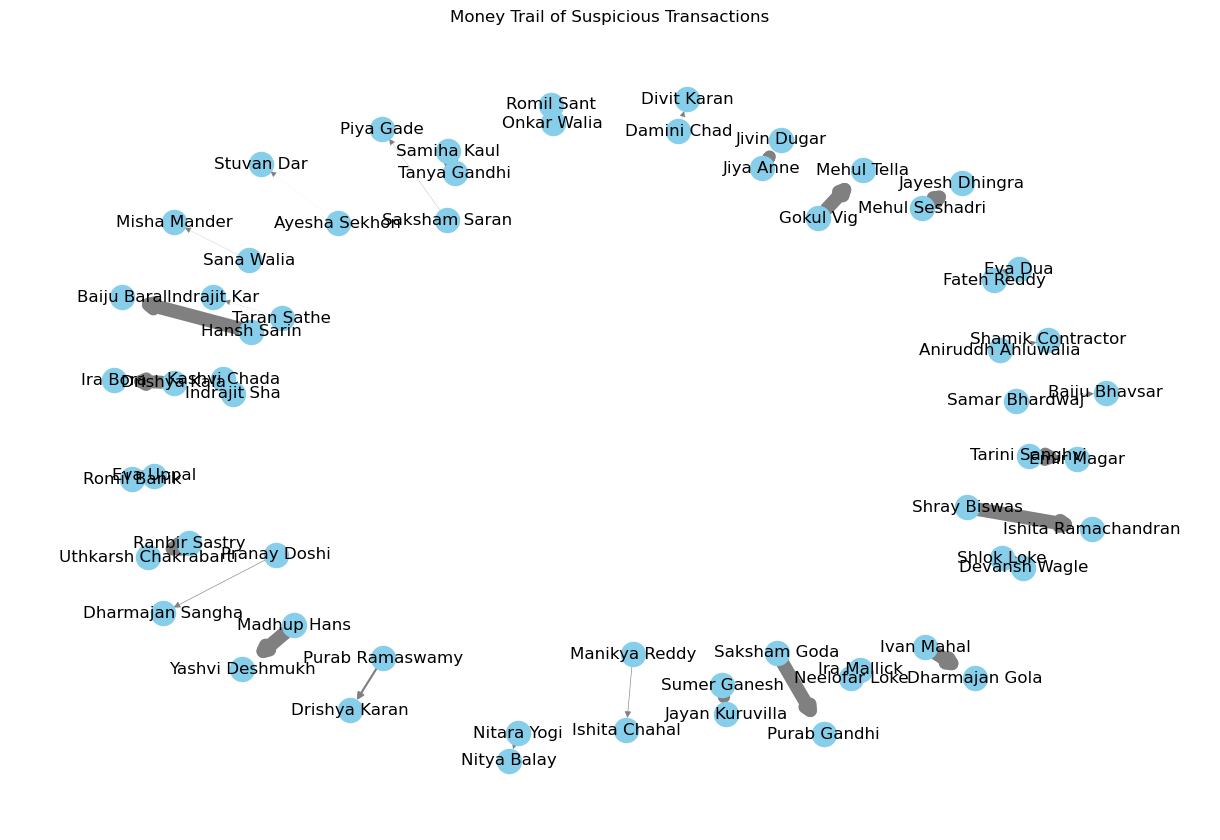

In [10]:
import networkx as nx

G = nx.DiGraph()
for _, row in fraud_report.iterrows():
    sender = row['Sender Name']
    receiver = row['Receiver Name']
    amount = row['Amount (INR)']
    G.add_edge(sender, receiver, weight=amount)

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=0.5)
edges = G.edges()
weights = [G[u][v]['weight']/1000 for u,v in edges]
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', width=weights, arrows=True)
plt.title('Money Trail of Suspicious Transactions')
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import joblib
import os

# Use 'is_suspicious' as label for demonstration (replace with real label if available)
if 'is_suspicious' not in df.columns:
    raise ValueError("No label column found for supervised learning.")

X = df[features]
y = df['is_suspicious']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

best_acc = 0
best_model = None
best_model_name = ""

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    if acc > best_acc:
        best_acc = acc
        best_model = clf
        best_model_name = name

print(f"\nBest model: {best_model_name} with accuracy {best_acc:.4f}")

# Save the best model
os.makedirs(r"C:\Users\sinha\OneDrive\Documents\Projects\Bihari Hackathon 2\BiharChalo\bank-fraud-detection\models", exist_ok=True)
model_path = r"C:\Users\sinha\OneDrive\Documents\Projects\Bihari Hackathon 2\BiharChalo\bank-fraud-detection\models\best_fraud_model.pkl"
joblib.dump(best_model, model_path)
print(f"Best model saved to {model_path}")

Logistic Regression Accuracy: 0.9700
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       194
           1       0.00      0.00      0.00         6

    accuracy                           0.97       200
   macro avg       0.48      0.50      0.49       200
weighted avg       0.94      0.97      0.96       200



c:\Users\sinha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sinha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sinha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Accuracy: 0.9950
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       194
           1       1.00      0.83      0.91         6

    accuracy                           0.99       200
   macro avg       1.00      0.92      0.95       200
weighted avg       1.00      0.99      0.99       200

SVM Accuracy: 0.9700
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       194
           1       0.00      0.00      0.00         6

    accuracy                           0.97       200
   macro avg       0.48      0.50      0.49       200
weighted avg       0.94      0.97      0.96       200


Best model: Random Forest with accuracy 0.9950
Best model saved to C:\Users\sinha\OneDrive\Documents\Projects\Bihari Hackathon 2\BiharChalo\bank-fraud-detection\models\best_fraud_model.pkl


c:\Users\sinha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sinha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sinha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
